Given the output of the production / simulation DAG
- compute the research PnL / output with the ForecastEvaluator from DAG
- compare production portfolio PnL / output

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import os

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import reconciliation as reconcil

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-f3ceb2e4-ba4c-41d4-8d1e-b1d08fa516e8.json'
INFO  # Git
  branch_name='AmpTask2534_Prod_reconciliation_01'
  hash='1154b9150'
  # Last commits:
    *   1154b9150 psmith   Merge branch 'master' into AmpTask2534_Prod_reconciliation_01     (34 minutes ago) Mon Sep 19 13:26:03 2022  (HEAD -> AmpTask2534_Prod_reconciliation_01, origin/AmpTask2534_Prod_reconciliation_01)
    |\  
    | * 597b8ce02 GP Saggese AmpTask1786_Integrate_20220916 (#2568)                            (  22 hours ago) Sun Sep 18 15:40:56 2022  (origin/master, origin/HEAD, master)
    | * 9c9094096 GP Saggese LimeTask574_Fix_jitter_in_bar_timestamp (#2567)                   (    3 days ago) Fri Sep 16 21:48:14 2022           
# Machine info
  system=Linux
  node name=9fec6cd15180
  release=3.10.0-1160.53.1.el7.x86_64
  version=#1 SMP Fri Jan 14 13:59:45 UTC 2022
  machine=x86_64
  processor=x86_64
  cpu count=

In [3]:
# find /share/data/cf_production/CF_2022_09_08 -name "cf_prod_system_log_dir" -type d
# /share/data/cf_production/CF_2022_09_08/job-sasm_job-jobid-1002410338/user_executable_run_0-1000005273093/cf_prod_system_log_dir

root_dir = (
    # "/data/tmp/AmpTask2534_Prod_reconciliation_20220901/system_log_dir.prod"
    "/data/cf_production/20220914/job.1002436966/job-sasm_job-jobid-1002436966/user_executable_run_0-1000005393900/cf_prod_system_log_dir"
)
# root_dir = "/app/system_log_dir"

In [4]:
date = "2022-09-14"
start_timestamp = pd.Timestamp(date + " 10:15:00", tz="America/New_York")
_LOG.info("start_timestamp=%s", start_timestamp)
end_timestamp = pd.Timestamp(date + " 15:45:00", tz="America/New_York")
_LOG.info("end_timestamp=%s", start_timestamp)

INFO  start_timestamp=2022-09-14 10:15:00-04:00
INFO  end_timestamp=2022-09-14 10:15:00-04:00


In [5]:
# hdbg.dassert_dir_exists(root_dir)
dict_ = {
    "freq": "15T",
    "start_timestamp": start_timestamp,
    "end_timestamp": end_timestamp,
}
#
config = cconfig.Config.from_dict(dict_)
display(config)

freq: 15T
start_timestamp: 2022-09-14 10:15:00-04:00
end_timestamp: 2022-09-14 15:45:00-04:00

# Load DAG IO

In [6]:
config_file_name = f"{root_dir}/system_config.output.txt"
print(config_file_name)
!cat {config_file_name}

/data/cf_production/20220914/job.1002436966/job-sasm_job-jobid-1002436966/user_executable_run_0-1000005393900/cf_prod_system_log_dir/system_config.output.txt
dag_config:
  filter_ath:
    col_mode: replace_all
    transformer_kwargs:
      start_time: 09:30:00
      end_time: 16:00:00
  zscore:
    in_col_groups: [('sided_bid_count',), ('sided_ask_count',)]
    out_col_group: ()
    transformer_kwargs:
      dyadic_tau: 7
    col_mapping:
      sided_bid_count: sided_bid_count.z
      sided_ask_count: sided_ask_count.z
    drop_nans: True
  compress_tails:
    in_col_groups: [('sided_bid_count.z',), ('sided_ask_count.z',)]
    out_col_group: ()
    transformer_kwargs:
      scale: 6
    col_mapping:
      sided_bid_count.z: sided_bid_count.zc
      sided_ask_count.z: sided_ask_count.zc
  cross_feature_pairs:
    in_col_groups: [('sided_bid_count.zc',), ('sided_ask_count.zc',)]
    out_col_group: ()
    transformer_kwargs:
      feature_groups: [('sided_bid_count.zc', 'sided_ask_count.z

In [7]:
dag_dir = os.path.join(root_dir, "dag/node_io/node_io.data")
print(dag_dir)
hdbg.dassert_dir_exists(dag_dir)

/data/cf_production/20220914/job.1002436966/job-sasm_job-jobid-1002436966/user_executable_run_0-1000005393900/cf_prod_system_log_dir/dag/node_io/node_io.data


In [8]:
stage = "0.read_data"
target_cols = [
    "ask",
    "bid",
    "close",
    "day_num_spread",
    "day_spread",
    "high",
    "low",
    "notional",
    "open",
    "sided_ask_count",
    "sided_bid_count",
    "start_time",
    "volume",
]
# stage = "2.zscore"
stage = "7.process_forecasts"
target_cols = [
    "close",
    "close_vwap",
    "day_num_spread",
    "day_spread",
    "garman_klass_vol",
    "high",
    "low",
    "notional",
    "open",
    "prediction",
    "twap",
    "volume",
]
timestamp = "20220914_154500"

file_name = f"predict.{stage}.df_out.{timestamp}.csv"
file_name = os.path.join(dag_dir, file_name)
print(file_name)
dag_df = pd.read_csv(file_name, parse_dates=True, index_col=0, header=[0, 1])

# dag_df = dag_df[start_timestamp:end_timestamp]

display(dag_df.head(3))

# print(dag_df.columns.levels[0])
# print(sim_dag_df.columns.levels[0])
# dag_df.drop(labels=["end_time"], axis=1, level=0, inplace=True, errors="raise")
asset_ids = dag_df.columns.levels[1].tolist()
# for col in dag_df.columns:
#     if col[0] in target_cols:
#     columns.append()
import itertools

columns = list(itertools.product(target_cols, asset_ids))
dag_df = dag_df[pd.MultiIndex.from_tuples(columns)].copy()
hpandas.df_to_str(dag_df, log_level=logging.INFO)
dag_df.to_csv("prod_tmp.csv")
dag_df = pd.read_csv("prod_tmp.csv", index_col=0, header=[0, 1])

asset_ids = map(int, asset_ids)
columns = list(itertools.product(target_cols, asset_ids))
columns = pd.MultiIndex.from_tuples(columns)
dag_df.columns = columns

dag_df.index = pd.to_datetime(dag_df.index)
dag_df.index = dag_df.index.tz_convert("America/New_York")

/data/cf_production/20220914/job.1002436966/job-sasm_job-jobid-1002436966/user_executable_run_0-1000005393900/cf_prod_system_log_dir/dag/node_io/node_io.data/predict.7.process_forecasts.df_out.20220914_154500.csv


garman_klass_vol                                                                                                                                                                                      close                                                                                                                                                   close_vwap                                                                                                                                                                                                                    day_num_spread                                                                                                                                                 day_spread                                                                                                                                                      high                                                                              \
                                     10365     11198     12007     12119     13412     13684     14527     14592     14881     15224     15740    15794     16224     16878     16897     17085     17109     17511     17933   10365   11198   12007    12119  13412     13684  14527     14592   14881  15224  15740   15794   16224    16878   16897   17085   17109   17511   17933      10365       11198       12007       12119      13412      13684       14527       14592       14881      15224      15740       15794       16224       16878      16897       17085       17109       17511       17933          10365   11198   12007   12119   13412   13684   14527   14592   14881   15224   15740   15794   16224   16878   16897   17085   17109   17511   17933      10365    11198    12007   12119   13412   13684    14527   14592   14881  15224   15740   15794   16224   16878    16897  17085    17109   17511   17933  10365  11198   12007  12119  13412   13684   14527   14592   14881   15224  15740   
end_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2022-09-12 09:15:00-04:00              NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN     NaN     NaN     NaN      NaN    NaN       NaN    NaN       NaN     NaN    NaN    NaN     NaN     NaN      NaN     NaN     NaN     NaN     NaN     NaN        NaN         NaN         NaN         NaN        NaN        NaN         NaN         NaN         NaN        NaN        NaN         NaN         NaN         NaN        NaN         NaN         NaN         NaN         NaN            NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN        NaN      NaN      NaN     NaN     NaN     NaN      NaN     NaN     NaN    NaN     NaN     NaN     NaN     NaN      NaN    NaN      NaN     NaN     NaN    NaN    NaN     NaN    NaN    NaN     NaN     NaN     NaN     NaN     NaN    NaN   
2022-09-12 09:30:00-04

close                                                                                                                                                                         close_vwap                                                                                                                                                                                                                      day_num_spread                                                                                                                                                                   day_spread                                                                                                                                                             garman_klass_vol                                                                                                                                                                                         high                                                                                                                                                             low                                                                                                                                                                     notional                                                                                                                                                                                                                                                                                                                             open                                                                                                                                                         prediction                                                                                                                                                                                            twap                                                                                                                                                                                                                         volume                                                                                                                                                                                          
                            10365     11198   12007    12119   13412     13684   14527     14592     14881   15224    15740     15794   16224     16878     16897     17085     17109    17511     17933       10365       11198       12007       12119      13412       13684       14527       14592       14881      15224      15740       15794       16224       16878       16897       17085       17109       17511       17933          10365    11198    12007    12119    13412    13684    14527    14592    14881    15224    15740    15794    16224    16878    16897    17085    17109    17511    17933      10365     11198    12007     12119   13412    13684    14527    14592    14881   15224   15740   15794   16224   16878    16897   17085    17109    17511   17933            10365     11198     12007     12119     13412     13684     14527     14592     14881     15224     15740     15794     16224     16878     16897     17085     17109     17511     17933    10365   11198     12007   12119   13412   13684   14527   14592     14881   15224   15740   15794   16224   16878   16897   17085   17109    17511     17933    10365   11198    12007     12119    13412     13684     14527   14592    14881  15224  15740   15794   16224     16878   16897     17085   17109    17511   17933            10365            11198            12007            12119             13412             13684            14527             14592            14881            15224            15740             15794             16224             16878           16897              17085            17109            17511            17933   10365   11

In [9]:
display(dag_df)

close                                                                                                                                                                                     close_vwap                                                                                                                                                                                                                      day_num_spread                                                                                                                                                                   day_spread                                                                                                                                                             garman_klass_vol                                                                                                                                                                                          high  \
                              10365       11198     12007     12119    13412     13684     14527     14592     14881    15224    15740     15794     16224     16878     16897     17085     17109     17511     17933       10365       11198       12007       12119      13412       13684       14527       14592       14881      15224      15740       15794       16224       16878       16897       17085       17109       17511       17933          10365    11198    12007    12119    13412    13684    14527    14592    14881    15224    15740    15794    16224    16878    16897    17085    17109    17511    17933      10365     11198    12007     12119   13412    13684    14527    14592    14881   15224   15740   15794   16224   16878    16897   17085    17109    17511   17933            10365     11198     12007     12119     13412     13684     14527     14592     14881     15224     15740     15794     16224     16878     16897     17085     17109     17511     17933     10365   
end_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2022-09-12 09:15:00-04:00       NaN         NaN       NaN       NaN      NaN       NaN       NaN       NaN       NaN      NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN         NaN         NaN         NaN         NaN        NaN         NaN         NaN         NaN         NaN        NaN        NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN            NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN        NaN       NaN      NaN       NaN     NaN      NaN      NaN      NaN      NaN     NaN     NaN     NaN     NaN     NaN      NaN     NaN      NaN      NaN     NaN              NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2022-09-12 09:30:00-04:00       NaN         NaN       

# Run ForecastEvaluator (vectorized research flow)

In [10]:
# From process_forecasts_dict
#   process_forecasts_dict:
#     order_config:
#       order_type: price@twap
#       order_duration_in_mins: 15
#     optimizer_config:
#       backend: pomo
#       params:
#         style: cross_sectional
#         kwargs:
#           bulk_frac_to_remove: 0.0
#           target_gmv: 20000.0

# From process_forecasts_node_dict
#   prediction_col: prediction
#  volatility_col: garman_klass_vol

fep_dict = {
    "price_col": "close_vwap",
    "prediction_col": "prediction",
    "volatility_col": "garman_klass_vol",
    #
    "quantization": 0,
    "burn_in_bars": 3,
    #
    "style": "cross_sectional",
    "bulk_frac_to_remove": 0.0,
    "target_gmv": 20000.0,
}
fep_config = cconfig.Config.from_dict(fep_dict)

In [11]:
fep = dtfmod.ForecastEvaluatorFromPrices(
    fep_config["price_col"],
    fep_config["volatility_col"],
    fep_config["prediction_col"],
)

In [12]:
research_portfolio_df, research_portfolio_stats_df = fep.annotate_forecasts(
    dag_df,
    # bulk_frac_to_remove=fep_config["bulk_frac_to_remove"],
    # bulk_fill_method=fep_config["bulk_fill_method"],
    target_gmv=fep_config["target_gmv"],
    quantization=fep_config["quantization"],
    burn_in_bars=fep_config["burn_in_bars"],
    style=fep_config["style"],
)
# bar_metrics.append(bar_metrics_slice)

/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1001) is greater than the total number of samples (19). n_quantiles is set to n_samples.
  warnings.warn(


<AxesSubplot:xlabel='end_time'>

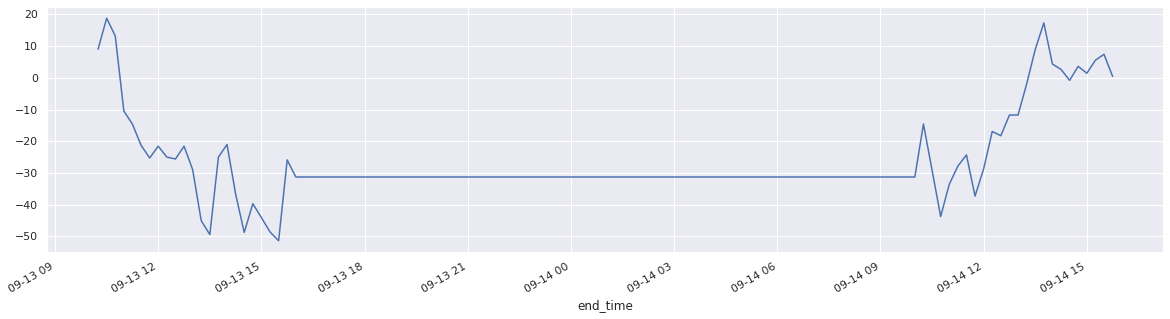

In [13]:
research_portfolio_stats_df["pnl"].cumsum().plot()

In [14]:
research_portfolio_df = research_portfolio_df.loc[start_timestamp:end_timestamp]
research_portfolio_stats_df = research_portfolio_stats_df.loc[
    start_timestamp:end_timestamp
]

# Load prod portfolio

In [15]:
prod_portfolio_dir = os.path.join(root_dir, "process_forecasts/portfolio")

In [16]:
prod_portfolio_df, prod_portfolio_stats_df = reconcil.load_portfolio_artifacts(
    prod_portfolio_dir,
    start_timestamp,
    end_timestamp,
    "15T",
    normalize_bar_times=True,
)

Loading `holdings` files...:   0%|          | 0/25 [00:00<?, ?it/s]

Loading `holdings_marked_to_market` files...:   0%|          | 0/25 [00:00<?, ?it/s]

Loading `flows` files...:   0%|          | 0/25 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/25 [00:00<?, ?it/s]

In [17]:
# hpandas.df_to_str(prod_portfolio_df, log_level=logging.INFO)

In [18]:
hpandas.df_to_str(prod_portfolio_stats_df, log_level=logging.INFO)

,pnl,gross_volume,net_volume,gmv,nmv,cash,net_wealth,leverage
2022-09-14 10:15:00-04:00,10.292556,8514.08,-1287.36,16218.093425,1199.316438,-1088.91,110.406438,146.894455
2022-09-14 10:30:00-04:00,5.409156,13508.6,-1355.32,15953.026569,-150.594406,266.41,115.815594,137.745066
2022-09-14 10:45:00-04:00,8.352571,7657.84,2749.2,14741.732998,2606.958165,-2482.79,124.168165,118.723934
,...,...,...,...,...,...,...,...
2022-09-14 15:15:00-04:00,5.041356,18171.08,1586.56,19050.118125,5890.001225,-5729.6,160.401225,118.765415
2022-09-14 15:30:00-04:00,-3.734806,9976.65,-1331.27,12519.050056,4554.996419,-4398.33,156.666419,79.908957
2022-09-14 15:45:00-04:00,-1.191494,16546.01,1339.07,20013.382613,5892.874925,-5737.4,155.474925,128.724182


# Compare prod and research stats

In [19]:
portfolio_stats_dfs = {
    "research": research_portfolio_stats_df,
    "prod": prod_portfolio_stats_df,
}
portfolio_stats_dfs = pd.concat(portfolio_stats_dfs, axis=1)

In [20]:
hpandas.df_to_str(portfolio_stats_dfs, log_level=logging.INFO)

research                                                              prod                                                                                    
                                 pnl  gross_volume    net_volume           gmv          nmv        pnl gross_volume net_volume           gmv          nmv     cash  net_wealth    leverage
2022-09-14 10:15:00-04:00  16.712262  15342.619922    -87.162835  20272.898582  6225.618111  10.292556      8514.08   -1287.36  16218.093425  1199.316438 -1088.91  110.406438  146.894455
2022-09-14 10:30:00-04:00 -14.532792  22446.357032  -4430.607607  19763.918478  1780.477711   5.409156      13508.6   -1355.32  15953.026569  -150.594406   266.41  115.815594  137.745066
2022-09-14 10:45:00-04:00 -14.642657  18403.452924  -3887.927245   20506.66751 -2122.092191   8.352571      7657.84     2749.2  14741.732998  2606.958165 -2482.79  124.168165  118.723934
                                 ...           ...           ...           ...          ...        ...          ...        ...           ...          ...      ...         ...         ...
2022-09-14 15:15:00-04:00   4.111037   19036.24544   4066.124401  19697.742421  5098.104551   5.041356     18171.08    1586.56  19050.118125  5890.001225  -5729.6  160.401225  118.765415
2022-09-14 15:30:00-04:00   1.877322  25895.539441 -14219.282558  20151.979687 -9119.300685  -3.734806      9976.65   -1331.27  12519.050056  4554.996419 -4398.33  156.666419   79.908957
2022-09-14 15:45:00-04:00  -6.972085  20162.472355    9126.27277           0.0          0.0  -1.191494     16546.01    1339.07  20013.382613  5892.874925  -5737.4  155.474925  128.724182

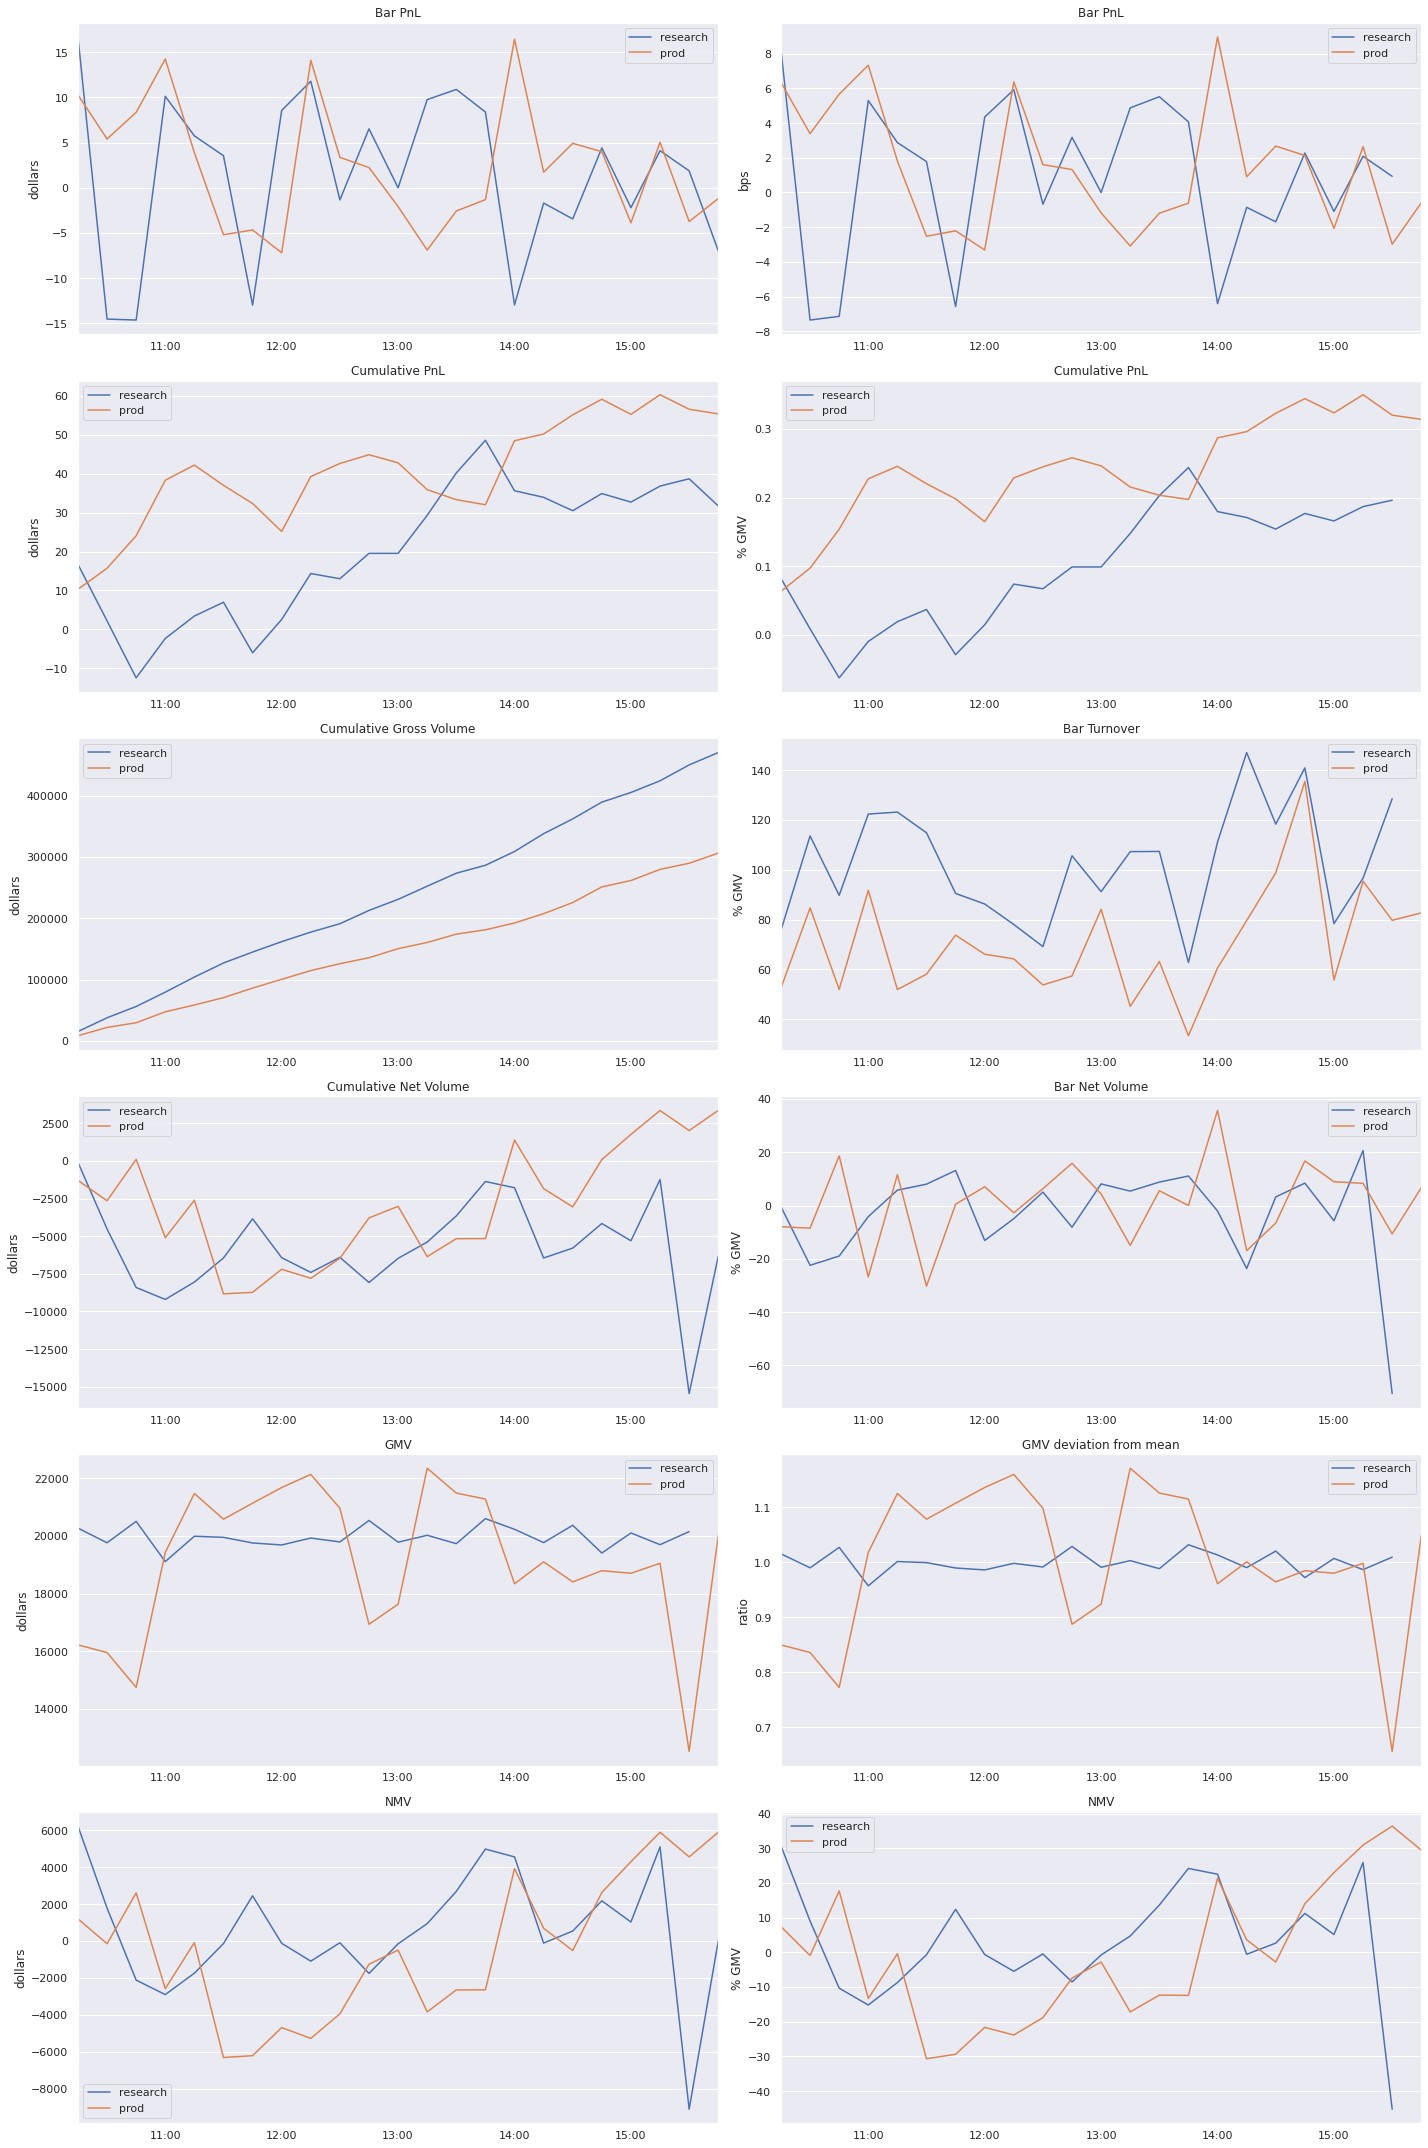

In [21]:
coplotti.plot_portfolio_stats(portfolio_stats_dfs)

In [22]:
cols = research_portfolio_stats_df.columns
portfolio_stats_corrs = dtfmod.compute_correlations(
    # TODO: Don't hardcode the tail trimming.
    prod_portfolio_stats_df[cols],
    research_portfolio_stats_df,
)
display(portfolio_stats_corrs.round(3))

,correlation
pnl,-0.053
gross_volume,0.432
net_volume,0.147
gmv,-0.105
nmv,0.005


# Compare prod and research portfolios (asset granularity)

In [23]:
prod_portfolio_df.columns.levels[0]

Index(['holdings', 'holdings_marked_to_market', 'flows', 'pnl'], dtype='object')

In [24]:
prod_portfolio_df.columns.levels[1]

Int64Index([-1, 10365, 11198, 12007, 12119, 13412, 13684, 14527, 14592, 14881, 15224, 15740, 15794, 16224, 16878, 16897, 17085, 17109, 17511, 17933], dtype='int64')

In [25]:
research_portfolio_df.columns.levels[0]

Index(['price', 'volatility', 'prediction', 'holdings', 'position', 'flow', 'pnl'], dtype='object')

In [26]:
normalized_research_portfolio_df = dtfmod.normalize_portfolio_df(
    research_portfolio_df
)

In [27]:
normalized_prod_portfolio_df = reconcil.normalize_portfolio_df(prod_portfolio_df)

In [28]:
portfolio_corrs = dtfmod.compute_correlations(
    normalized_prod_portfolio_df,
    normalized_research_portfolio_df,
)
display(portfolio_corrs.round(3))

,holdings,holdings_marked_to_market,flows,pnl
10365,0.668,0.667,0.494,0.378
11198,0.525,0.526,0.326,0.691
12007,0.775,0.777,0.690,0.860
12119,0.701,0.703,0.679,0.561
13412,0.983,0.983,0.985,0.996
13684,0.898,0.899,0.796,0.855
14527,0.029,0.028,0.303,0.036
14592,0.952,0.953,0.975,0.949
14881,0.911,0.912,0.902,0.995
15224,0.922,0.923,0.952,0.985
